# KYBS3050 Koneoppimismenetelmiä
## Final excersise, fall 2020
16.12.2020
Jyri Putkonen


## Description of the data and goal of the exercise

I used dataset IoT-23 collected by CTU University, Czech Republic Stratosphere Laboratory:

“Stratosphere Laboratory. A labeled dataset with malicious and benign IoT network traffic. January 22th. Agustin Parmisano, Sebastian Garcia, Maria Jose Erquiaga. https://www.stratosphereips.org/datasets-iot23

Scenarios and the set are interesting because data is novel and amount and importance of IoT equipment is increasing due to ubiqutous digitalisation of the society and possible cyber-physical consequences of malicious operations. Data is well documented and labeled. It is published in January 2020. Seems that it is much utilised in student works recently.

Data is collected in a closed controlled network. There are three different IoT equipment and a half-dozen malware attack types in several scenarios. Also bening, i.e. normal samples are included.

From over 20 Gbytes of data I selected one 24 hour 120 MB sample (233 000 packets, 23 145 rows in a Zeek file) containing bening and Mirai-bot malware traffic. Packet data collection format is PCAP and its' traffic flows are semi-manually labelled using Zeek analyser and a Python scrip by the Stratos researchers. In addition to bening traffic there are DDos, botnet command and control (C&C) and hartbeat traffic and horizontal port scans.

Mirai Botnet is a malicios program used for DoS/DDoS (distributed denial of servive) attacks. Mirai utilises Linux and ARC-processor vulnerabiliites to spread from one IoT device to an other. It was first discovered in 2016 and there are several version spreading today. It spreads automatically. Infected devices are controlled centrally from a botnet command server using C&C channel. When equipment is infected it starts scanning local network. It sends TCP SYN-packets to IPv4 addresses' TCP-ports 23 or 2323 using Telnet protocol in order establish a Telnet connection. If succeeds connecting and IoT equipment gets infected it starts periodically sending C&C packets to the botnet controller.

In [39]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
#from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

I set my target to be able to categorise bening and malware traffic, especially Command&Control traffic of botnet with machine learning algorithms introduced at the course.

First I preprocessed the data. I studied the Stratos pages and description of the data. Then I converted the PCAP and Zeek data files to .csv/-tsv format with Wireshark. I browsed the data with Python Pandas table to decide how to go on.

In [40]:
mal = pd.read_csv("jd_labeled_c.tsv", sep="\t", header=0)

There are also bening, i.e. clean or normal data samples available for all IoT devices: Philips Hue lamp, Somfy door lock and Amazon Echo home assistant devices. It was not possible to access Amazon Echo files.

In [41]:
ben_phi = pd.read_csv("be_philips_labeled_c.tsv", sep="\t", header=0)
ben_som = pd.read_csv("be_soomfy_labeled_c.tsv", sep="\t", header=0)

Raw data pre-processing and identifying unique values. Select columns for further processing. Rename some columns for easier handling.

In [42]:
mal = mal.rename(columns={"tunnel_parents   label   detailed-label":"label", "id.orig_p":"orig_port", "id.resp_p":"resp_port"})
print(mal.label.unique())
print(mal.proto.unique())
print(mal.service.unique())
print(mal.conn_state.unique())
print(mal.local_orig.unique(), mal.local_resp.unique())
print(mal.missed_bytes.unique())
print(mal.history.unique())
print(mal.orig_ip_bytes.max())
mal2 = mal.drop(["ts","uid","id.orig_h","id.resp_h","history"], axis=1)
#mal2 = mal2.drop(["orig_bytes","resp_bytes"], axis=1)
mal2 = mal2.drop(["orig_port","resp_port"], axis=1)
mal2 = mal2.drop(["local_orig","local_resp","missed_bytes"], axis=1)
mal2 = mal2.drop(["service"], axis=1)
mal2 = mal2.drop(["conn_state"], axis=1)

['-   Benign   -' '-   Malicious   C&C'
 '-   Malicious   PartOfAHorizontalPortScan' '-   Malicious   DDoS']
['tcp' 'udp']
['-' 'http' 'irc' 'dns' 'dhcp']
['S0' 'SF' 'S3' 'RSTR' 'S1' 'OTH']
['-'] ['-']
[   0 2896 5792]
['S' 'ShADadttcfF' 'ShADadtcfF' 'Dd' 'D' 'ShADadtctfF' 'DdAtaFf' 'ShAdDaf'
 'ShADacdtfF' 'ShADadtctfFR' 'ShAdDaft' 'ShADadttfF' 'ShAdfDr' 'ShAfdtDr'
 'ShAdDatf' 'ShAdDatfr' 'ShDadAf' 'ShAdD' 'ShADadf' 'ShAdDfr' 'ShAD' 'C'
 'CCCC' 'CCC' 'ShADad' 'ShAdDa']
76063056


In [43]:
#mal2 = mal2.replace({"-   Benign   -" : "ben", "-   Malicious   C&C" : "cc", "-   Malicious   DDoS" : "ddos", "-   Malicious   PartOfAHorizontalPortScan" : "scan"})
mal2 = mal2.replace({"-   Benign   -":0, "-   Malicious   C&C":1, "-   Malicious   DDoS":2, "-   Malicious   PartOfAHorizontalPortScan":3})
mal2 = mal2.replace({"tcp":0, "udp":1})
mal2 = mal2.replace({"-":0, "http":1, "irc":2, "dns":3, "dhcp":4})
mal2 = mal2.replace({"-":0})
#mal2 = mal2.astype({"proto":str,"service":str})
mal2 = mal2.astype({"duration":float})
#mal2 = mal2.astype({"orig_port":int, "resp_port":int})
mal2 = mal2.astype({"orig_pkts":int, "orig_ip_bytes":int, "resp_pkts":int, "resp_ip_bytes":int})
mal2 = mal2.astype({"orig_bytes":int, "resp_bytes":int})
mal2 = mal2[mal2.duration < 100]
mal2 = mal2[mal2.orig_ip_bytes < 8000]
mal2 = mal2[mal2.resp_ip_bytes < 8000]
#mal2 = mal2[mal2.label == 2]
feature = list(mal2.columns[:-1])
traffic = ["ben","cc","ddos","scan"]
mal3 = mal2.to_numpy()

I selected these columns/dimensions to further analysis based on information about the nature of the network traffic.

Converted labels:
0 = bening traffic
1 = malicious C&C
2 = malicious DDOS

Parameters like IP-address, port number, protocoll and service are nominal or ordinal levels of measurement, i.e. there is no sense to calculate distances between them, but other means like grouping or logical operations  e.g. one-hot -coding may be applied. Duration and number of bytes and packets represent ratio scale and all measures apply.

Lets heck how the data for model development looks like.

In [44]:
print(mal2)
print(mal2.min(axis=0), "\n", mal2.mean(axis=0), "\n", mal2.max(axis=0))
print(mal2[mal2.label == 3].shape)

       proto   duration  orig_bytes  resp_bytes  orig_pkts  orig_ip_bytes  \
0          0   3.139211           0           0          3            180   
1          0   0.000000           0           0          1             60   
2          0   0.000000           0           0          1             60   
4          0   3.147116           0           0          3            180   
8          0   3.114215           0           0          3            180   
...      ...        ...         ...         ...        ...            ...   
23140      0  32.840994          62         269          7            434   
23141      0  36.290833          62         260         10            606   
23142      1   0.000000           0           0          1             76   
23143      1   0.000000           0           0          1             76   
23144      1   0.000000           0           0          1             76   

       resp_pkts  resp_ip_bytes  label  
0              0              0   

Separate data and labels, split data and target to train and test sets.

In [45]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(mal3[:,:-1], mal3[:,-1], test_size=0.33, random_state=100)
print(data_train.shape)
print(target_train.shape)

(15472, 8)
(15472,)


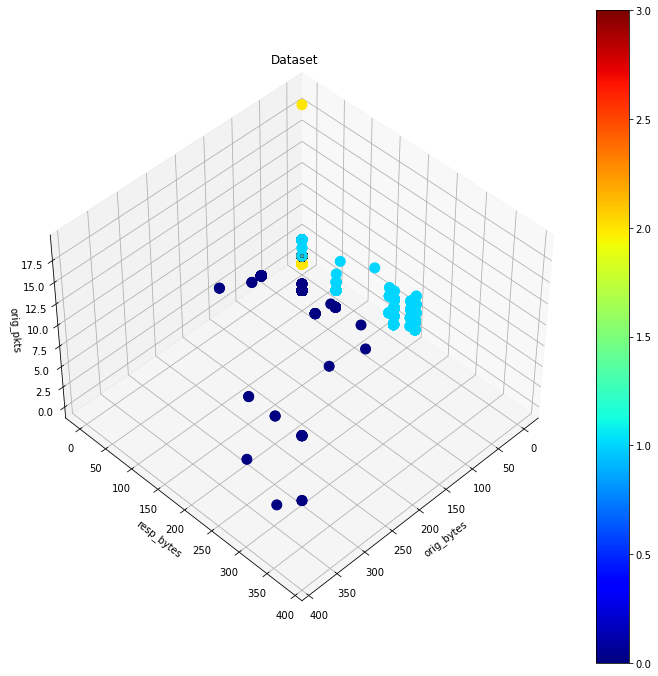

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure(figsize=(12,12)).gca(projection='3d')
ax = plt.gca()
x = data_train[:,2]
y = data_train[:,3]
z = data_train[:,4]
ax.scatter(x, y, z, s=100, cmap="jet", c=target_train, alpha=1)
ax.set_xlabel(feature[2])
ax.set_ylabel(feature[3])
ax.set_zlabel(feature[4])
plt.title('Dataset')
p = ax.scatter(x, y, z, cmap="jet", c=target_train, marker=".")
plt.colorbar(p)
ax.view_init(45,45)
plt.show()

Normalise features

In [47]:
from sklearn import preprocessing
data_train = preprocessing.normalize(data_train, norm='l2', axis=1)
data_test = preprocessing.normalize(data_test, norm='l2', axis=1)
target_train = target_train.astype(int)
target_test = target_test.astype(int)
print("var: %.4f" % np.var(data_train))
print("mean: %.4f" % np.mean(data_train))
print("min:", np.min(data_train))
print("max:", np.max(data_test))

var: 0.0442
mean: 0.0602
min: 0.0
max: 0.9998611400396


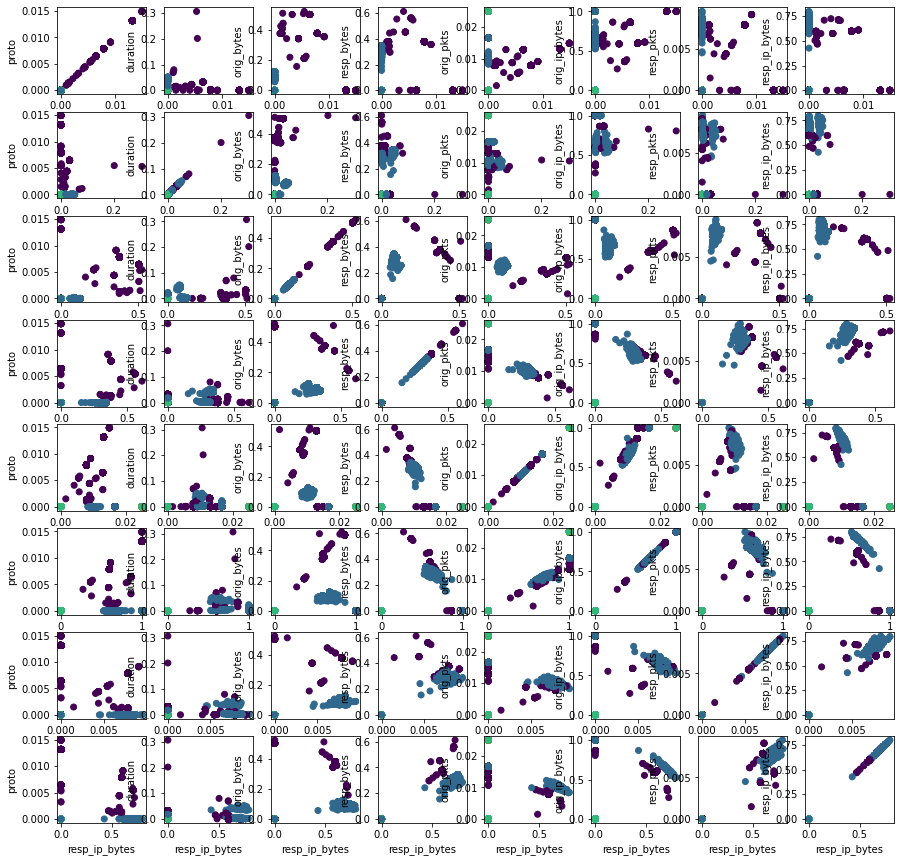

In [48]:
k=0
plt.figure(figsize=(15,15))
for i in range(data_train.shape[1]):
    for j in range(data_train.shape[1]):
        k = k+1
        plt.subplot(data_train.shape[1],data_train.shape[1],k)
        plt.scatter(data_train[:,i],data_train[:,j],c=target_train)
        plt.xlabel(feature[i])
        plt.ylabel(feature[j])
plt.show()

# Unsupervised learning

## Principal Component Analysis PCA - reduce dimensions

In [49]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)
pca_score = pca.fit_transform(data_train)
eig_val = pca.explained_variance_ratio_
print("Eigenvalues: ", eig_val, " , Explain: ", np.sum(eig_val))

Eigenvalues:  [7.78003648e-01 2.06101832e-01 1.49300491e-02 7.09984738e-04
 2.28556025e-04]  , Explain:  0.9999740706510818


In [50]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=feature)
loadings

,PC1,PC2,PC3,PC4,PC5
proto,0.002185,0.001702,0.018566,0.034343,-0.075105
duration,0.009150,0.008070,-0.011822,-0.193614,0.977503
orig_bytes,0.044950,0.238129,0.945354,-0.215254,-0.032439
resp_bytes,0.065177,0.428522,0.094771,0.879128,0.172818
orig_pkts,0.016148,-0.003764,-0.004363,-0.003679,0.009490
orig_ip_bytes,0.987916,-0.153686,-0.007588,0.003910,-0.007266
resp_pkts,0.001498,0.009722,-0.000501,-0.000306,-0.011373
resp_ip_bytes,0.131919,0.857827,-0.311067,-0.376968,-0.087503


The dominating loading features per Principal Componet:
- PC1: orig_ip_bytes (5)
- PC2: resp_ip_bytes (7)
- PC3: orig_bytes (1)
- PC4: resp_bytes (2)
- PC5: duration (0)

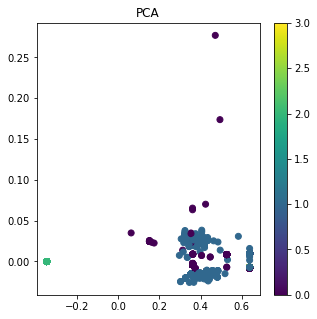

In [51]:
plt.figure(figsize=(5,5))
plt.scatter(pca_score[:,0],pca_score[:,4],c=target_train)
plt.title('PCA')
plt.colorbar()
plt.show()

## K-means clustering

In [66]:
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
cluster_kmeans = cluster.KMeans(n_clusters=4).fit_predict(pca_score[:,(0,1)])
#cluster_kmeans = cluster.KMeans(n_clusters=4).fit_predict(data_train[:,(5,0)])

In [67]:
cm_kmean = confusion_matrix(cluster_kmeans, target_train)
print("K-means:\n", pd.DataFrame(cm_kmean, index=traffic, columns=traffic))
print(classification_report(cluster_kmeans, target_train, target_names=traffic))

K-means:
       ben    cc  ddos  scan
ben     0     0  9554     0
cc    643  3368    87    73
ddos  584  1061     0     0
scan  101     1     0     0
              precision    recall  f1-score   support

         ben       0.00      0.00      0.00      9554
          cc       0.76      0.81      0.78      4171
        ddos       0.00      0.00      0.00      1645
        scan       0.00      0.00      0.00       102

    accuracy                           0.22     15472
   macro avg       0.19      0.20      0.20     15472
weighted avg       0.20      0.22      0.21     15472



## DBSCAN density based clustering

In [42]:
cluster_db = cluster.DBSCAN(eps=0.05, min_samples=4, metric='euclidean').fit_predict(pca_score)
#cluster_db = cluster.DBSCAN(eps=0.05, min_samples=4, metric='euclidean').fit_predict(data_train)

In [43]:
print("DBSCAN:\n", confusion_matrix(cluster_db, target_train))
print(classification_report(cluster_db, target_train))


DBSCAN:
 [[   0    2    2    0    0    0]
 [   0    0    0 9554    0    0]
 [   0  643 3368   87   73    0]
 [   0  568 1060    0    0    0]
 [   0   14    0    0    0    0]
 [   0  101    0    0    0    0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.00      0.00      0.00      9554
           1       0.76      0.81      0.78      4171
           2       0.00      0.00      0.00      1628
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00       101

    accuracy                           0.22     15472
   macro avg       0.13      0.13      0.13     15472
weighted avg       0.20      0.22      0.21     15472



/home/jyri/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DBSCAN is not good because it does not know the number of target categories.

## ROC and AUC

In [44]:
def draw_roc(tmp_tar,tmp_cl):
    
    fpr, tpr, thresholds = metrics.roc_curve(tmp_tar,tmp_cl, pos_label=0)
    roc_auc = metrics.roc_auc_score(tmp_tar,tmp_cl)
    lw =2
    plt.figure(figsize=(5,5))
    plt.plot(tpr, fpr, color='red',lw=lw,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
tar_tmp = np.zeros_like(cluster_db)
tar_tmp[cluster_db>-1] = 1
cl_tmp = np.zeros_like(tar_tmp)
cl_tmp[cluster_db==1] = 1
cl_tmp[0:3] = 1 
fpr, tpr, thresholds = metrics.roc_curve(tar_tmp,cl_tmp, pos_label=0)
roc_auc = metrics.roc_auc_score(tar_tmp,cl_tmp)

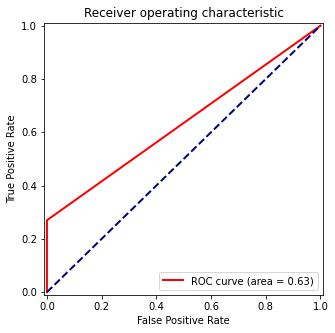

In [46]:
draw_roc(tar_tmp,cl_tmp)

# Supervised learning

## SVM

In [20]:
from sklearn import svm
classif_svm = svm.SVC(kernel='linear', C=10, probability=True)
#classif_svm = svm.SVC(kernel='rbf', gamma=0.1, C=1, probability=True)
classif_svm.fit(data_train, target_train)

SVC(C=10, kernel='linear', probability=True)

In [21]:
pred_svm = classif_svm.predict(data_test)
print(pred_svm)
cm_svm = confusion_matrix(pred_svm, target_test)
print("SVM:\n", pd.DataFrame(cm_svm, index=traffic, columns=traffic))
print(classification_report(pred_svm, target_test, target_names=traffic))

[0 2 2 ... 2 2 2]
SVM:
       ben    cc  ddos  scan
ben   544     0     0     0
cc     30  2268    36    38
ddos    0     0  4706     0
scan    0     0     0     0
              precision    recall  f1-score   support

         ben       0.95      1.00      0.97       544
          cc       1.00      0.96      0.98      2372
        ddos       0.99      1.00      1.00      4706
        scan       0.00      0.00      0.00         0

    accuracy                           0.99      7622
   macro avg       0.74      0.74      0.74      7622
weighted avg       0.99      0.99      0.99      7622



/home/jyri/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

[Text(612.05625, 781.425, 'X[4] <= 0.001\ngini = 0.522\nsamples = 15472\nvalue = [1328, 4430, 9641, 73]'),
 Text(570.2062500000001, 713.4749999999999, 'gini = 0.0\nsamples = 9554\nvalue = [0, 0, 9554, 0]'),
 Text(653.90625, 713.4749999999999, 'X[0] <= 0.0\ngini = 0.389\nsamples = 5918\nvalue = [1328, 4430, 87, 73]'),
 Text(612.05625, 645.525, 'X[4] <= 0.021\ngini = 0.092\nsamples = 4650\nvalue = [60, 4430, 87, 73]'),
 Text(528.35625, 577.5749999999999, 'X[1] <= 0.001\ngini = 0.013\nsamples = 4460\nvalue = [30, 4430, 0, 0]'),
 Text(486.50625, 509.62499999999994, 'gini = 0.028\nsamples = 1628\nvalue = [23, 1605, 0, 0]'),
 Text(570.2062500000001, 509.62499999999994, 'X[5] <= 1.0\ngini = 0.005\nsamples = 2832\nvalue = [7, 2825, 0, 0]'),
 Text(528.35625, 441.67499999999995, 'gini = 0.0\nsamples = 1063\nvalue = [0, 1063, 0, 0]'),
 Text(612.05625, 441.67499999999995, 'X[1] <= 0.018\ngini = 0.008\nsamples = 1769\nvalue = [7, 1762, 0, 0]'),
 Text(470.8125, 373.72499999999997, 'X[1] <= 0.017\ngi

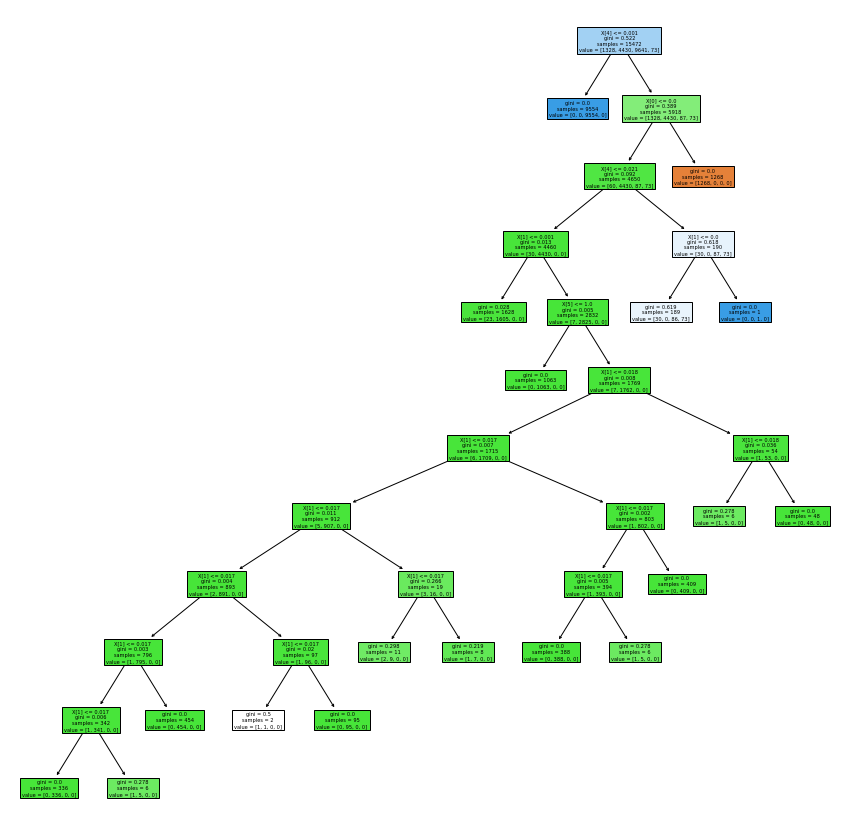

In [22]:
from sklearn import tree
from sklearn.model_selection import cross_val_predict

classif_dt = tree.DecisionTreeClassifier()
classif_dt = classif_dt.fit(data_train, target_train)
plt.figure(figsize=(15,15))
tree.plot_tree(classif_dt, filled=True)

In [23]:
pred_dt = classif_dt.predict(data_test)
pred_dt

array([0, 2, 2, ..., 2, 2, 2])

In [24]:
cm_dt = confusion_matrix(pred_dt, target_test)
cr_dt = classification_report(pred_dt, target_test, target_names=traffic)

print(pd.DataFrame(cm_dt, index=traffic, columns=traffic))
print(cr_dt)

      ben    cc  ddos  scan
ben   544     5     0     0
cc     23  2263     0     0
ddos    7     0  4742    38
scan    0     0     0     0
              precision    recall  f1-score   support

         ben       0.95      0.99      0.97       549
          cc       1.00      0.99      0.99      2286
        ddos       1.00      0.99      1.00      4787
        scan       0.00      0.00      0.00         0

    accuracy                           0.99      7622
   macro avg       0.74      0.74      0.74      7622
weighted avg       1.00      0.99      0.99      7622



/home/jyri/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Identifying Horizontal Scan traffic seems to be hard even for suprevised learning, because there are only a few occurrencies in the sample and because features do not provide much varieance i.e,. information about this (mainly = 0).

## Neural network

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D,MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


Try Deep Neural network

In [26]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(8,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary()) 
print(data_train.shape)
print(target_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
_________________________________________________________________
activation (Activation)      (None, 4)                 0

In [27]:
tr = target_train
ts = target_test
target_train = tf.keras.utils.to_categorical(target_train, 4)
target_test = tf.keras.utils.to_categorical(target_test, 4)
print(target_train)
print(target_train.shape)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
(15472, 4)


In [28]:
history = model.fit(data_train, target_train, epochs=30, batch_size=128, shuffle=True, validation_data=(data_test,target_test))

Epoch 1/30
121/121 [==============================] - 2s 13ms/step - loss: 1.1281 - accuracy: 0.4595 - val_loss: 0.4165 - val_accuracy: 0.9516
Epoch 2/30
121/121 [==============================] - 1s 8ms/step - loss: 0.2970 - accuracy: 0.9205 - val_loss: 0.1636 - val_accuracy: 0.9521
Epoch 3/30
121/121 [==============================] - 1s 10ms/step - loss: 0.2033 - accuracy: 0.9389 - val_loss: 0.1384 - val_accuracy: 0.9521
Epoch 4/30
121/121 [==============================] - 1s 9ms/step - loss: 0.1676 - accuracy: 0.9482 - val_loss: 0.1063 - val_accuracy: 0.9862
Epoch 5/30
121/121 [==============================] - 1s 8ms/step - loss: 0.1351 - accuracy: 0.9633 - val_loss: 0.0858 - val_accuracy: 0.9862
Epoch 6/30
121/121 [==============================] - 1s 9ms/step - loss: 0.1166 - accuracy: 0.9740 - val_loss: 0.0738 - val_accuracy: 0.9862
Epoch 7/30
121/121 [==============================] - 1s 10ms/step - loss: 0.1042 - accuracy: 0.9787 - val_loss: 0.0721 - val_accuracy: 0.9862
Epo

Accuracy and Loss curves

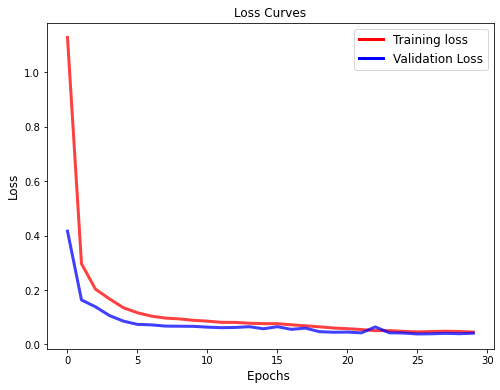

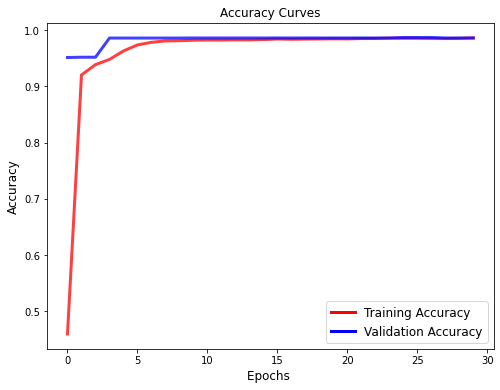

In [29]:
plt.figure(figsize=[8,6])
train_line = plt.plot(history.history['loss'],'r',linewidth=3.0)
val_line  = plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=12)
plt.setp(train_line, color='r', alpha=0.75)
plt.setp(val_line, color='b', alpha=0.75)

plt.figure(figsize=[8,6])
train_line = plt.plot(history.history['accuracy'],'r',linewidth=3.0)
val_line  = plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=12)
plt.setp(train_line, color='r', alpha=0.75)
plt.setp(val_line, color='b', alpha=0.75)

plt.show()

In [30]:
pred_dl = np.argmax(model.predict(data_test), axis=-1)

array([0, 2, 2, ..., 2, 2, 2])

In [32]:
cm_dl = confusion_matrix(pred_dl, ts)
cr_dl = classification_report(pred_dl, ts, target_names=traffic)
print(pd.DataFrame(cm_dl, index=traffic, columns=traffic))
print(cr_dl)

      ben    cc  ddos  scan
ben   544     0     0     0
cc     30  2268    36    38
ddos    0     0  4706     0
scan    0     0     0     0
              precision    recall  f1-score   support

         ben       0.95      1.00      0.97       544
          cc       1.00      0.96      0.98      2372
        ddos       0.99      1.00      1.00      4706
        scan       0.00      0.00      0.00         0

    accuracy                           0.99      7622
   macro avg       0.74      0.74      0.74      7622
weighted avg       0.99      0.99      0.99      7622



/home/jyri/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural network converges and fits pretty nicely with this amount of epochs. Visually no under or over-fitting observed.

## Conclusions
Network data requires some pre-processing first into traffic streams and then selecting needed features to analysis. Also the raw data I used included some partly manual work in labelling phase. There are big variation and skewness in data that causes shadowing which is handled by manually limiting data. This probably affects the results and would require more detailed anomaly analysis.

Features selected to my model development can be captured pretty easily from network traffic. With these parameters unsupervised models give poor results and they hardly can identify one traffic class with mediocre reliability. Supervised models are all much better and deep learning model gives very good results and fit and converge nicely in decent time. Especialaly C&C traffic can be caught, but Hozizontal Scanning is almost undetectable.

For further consideration:
- how to utilise aggreagting variables (in Mishin)
- handling of nominal data i.e. classes
- application of anomaly and outlier detection methods
- larger data sets containg more and different kind of traffic


## References
To better understand how to process TCP/IP traffic and detect malicious traffic I did a brief literature study and seeked for ideas how others have utilised similar data with similar problems:
1. Mishin, Mikhail (2020). Anomaly Detection Algorithms and Techniques for Network Intrusion Detection System (Diplomityö). Aalto-yliopisto.
2. Ring, Markus ym. (2017). IP2Vec: Learning Similarities between IP Addresses. Teoksessa 2017 IEEE Int Conf on Data Mining Workshops.
3. Marin, Gonzalo ym. (2020). DeepMAL - Deep Learning Models for Malware Traffic Detection and Classification.
4. Dutta, Vibekananda (2020). A Deep Learning Ensemble for Network Anomaly and Cyber-Attack Detection.
5. Bekerman, Dmitri ym. (2015). Unknown Malware Dteection Using Network Traffic Classification. Teoksessa 2015 IEEE Conf on Communications and Network Securoty (CNS).
6. Stoian, Nicolas-Alin (). Machine Learning for Anomaly Detection in IoT networks:Malware analysis on the IoT-23 Data set
7. Zeek documentation. Noudettu 7.12.2020. https://docs.zeek.org/en/current/scripts/base/protocols/conn/main.zeek.html